In [1]:
# %matplotlib notebook
from model.self_pose import SelfPose
from dataloader import XRegoDataset 
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
import time
import copy
import torch
import numpy as np
import cv2
import matplotlib.pyplot as plt
import webdataset as wds
from torchvision import transforms
import glob
from webdataset.handlers import ignore_and_continue
from PIL import Image
import io
import imgaug.augmenters as iaa
# import pytorch3d
# from mpl_toolkits.mplot3d import axes3d 


In [37]:

seq = iaa.Sequential(
    [   
        iaa.Resize({"height": 800, "width": 1280}),
#         iaa.SomeOf((0, 0),
#             [
#                 iaa.Sometimes(0.34, iaa.OneOf([
#                     iaa.GaussianBlur((0, 3.0)), # blur images with a sigma between 0 and 3.0
#                     iaa.AverageBlur(k=(2, 7)), # blur image using local means with kernel sizes between 2 and 7
#                     iaa.MedianBlur(k=(3, 7)), # blur image using local medians with kernel sizes between 2 and 7
#                 ])),
#                 iaa.Sometimes(0.3, iaa.Sharpen(alpha=(0, 1.0), lightness=(0.75, 1.5))), # sharpen images 
#                 # search either for all edges or for directed edges,
#                 # blend the result with the original image using a blobby mask
#                 iaa.Sometimes(0.3, iaa.SimplexNoiseAlpha(iaa.OneOf([
#                     iaa.EdgeDetect(alpha=(0.5, 1.0)),
#                     iaa.DirectedEdgeDetect(alpha=(0.5, 1.0), direction=(0.0, 1.0)),
#                 ]))),
#                 iaa.Sometimes(0.3, iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.05*255), per_channel=0.5)), # add gaussian noise to images
#                 iaa.Sometimes(0.45, iaa.OneOf([
#                     iaa.Dropout((0.01, 0.1), per_channel=0.5), # randomly remove up to 10% of the pixels
#                     iaa.CoarseDropout((0.03, 0.15), size_percent=(0.02, 0.05), per_channel=0.2),
#                 ])),
#                 iaa.Sometimes(0.55, iaa.Add((-10, 10), per_channel=0.5)), # change brightness of images (by -10 to 10 of original value)
#                 iaa.Sometimes(0.55, iaa.AddToHueAndSaturation((-20, 20))), # change hue and saturation
#                 # either change the brightness of the whole image (sometimes
#                 # per channel) or change the brightness of subareas
              
#                 iaa.Sometimes(0.55, iaa.Multiply((0.5, 1.5), per_channel=0.5)),
                    
#                 iaa.Sometimes(0.5, iaa.LinearContrast((0.5, 2.0), per_channel=0.5))
#             ],
#             random_order=True
#         )
    ],
    random_order=True
) 

In [38]:

preproc = transforms.Compose([

    transforms.ToTensor(),
#     normalize,
])

def Gaussian(sigma):
    if sigma == 7:
        return np.array([1.23409802e-04, 1.50343915e-03, 6.73794700e-03, 1.11089963e-02,
                     6.73794700e-03, 1.50343915e-03, 1.23409802e-04, 1.50343915e-03,
                     1.83156393e-02, 8.20849985e-02, 1.35335281e-01, 8.20849985e-02,
                     1.83156393e-02, 1.50343915e-03, 6.73794700e-03, 8.20849985e-02,
                     3.67879450e-01, 6.06530666e-01, 3.67879450e-01, 8.20849985e-02,
                     6.73794700e-03, 1.11089963e-02, 1.35335281e-01, 6.06530666e-01,
                     1.00000000e+00, 6.06530666e-01, 1.35335281e-01, 1.11089963e-02,
                     6.73794700e-03, 8.20849985e-02, 3.67879450e-01, 6.06530666e-01,
                     3.67879450e-01, 8.20849985e-02, 6.73794700e-03, 1.50343915e-03,
                     1.83156393e-02, 8.20849985e-02, 1.35335281e-01, 8.20849985e-02,
                     1.83156393e-02, 1.50343915e-03, 1.23409802e-04, 1.50343915e-03,
                     6.73794700e-03, 1.11089963e-02, 6.73794700e-03, 1.50343915e-03,
                     1.23409802e-04]).reshape(7,7)
    elif sigma == n:
        return g_inp
    else:
        raise Exception('Gaussian {} Not Implement'.format(sigma))

def DrawGaussian(img, pt, sigma):
    tmpSize = int(np.math.ceil(3 * sigma))
    ul = [int(np.math.floor(pt[0] - tmpSize)), int(np.math.floor(pt[1] - tmpSize))]
    br = [int(np.math.floor(pt[0] + tmpSize)), int(np.math.floor(pt[1] + tmpSize))]

    if ul[0] > img.shape[1] or ul[1] > img.shape[0] or br[0] < 1 or br[1] < 1:
        return img

    size = 2 * tmpSize + 1
    g = Gaussian(size)
    g_x = [max(0, -ul[0]), min(br[0], img.shape[1]) - max(0, ul[0]) + max(0, -ul[0])]
    g_y = [max(0, -ul[1]), min(br[1], img.shape[0]) - max(0, ul[1]) + max(0, -ul[1])]

    img_x = [max(0, ul[0]), min(br[0], img.shape[1])]
    img_y = [max(0, ul[1]), min(br[1], img.shape[0])]

    img[img_y[0]:img_y[1], img_x[0]:img_x[1]] = g[g_y[0]:g_y[1], g_x[0]:g_x[1]]
    return img

def get_heatmap(points, shape, new_shape=(51,51), joints=6):
    height, width = shape[0], shape[1]
    points[:, 0] = (points[:, 0] / width) * new_shape[1]
    points[:, 1] = (points[:, 1] / height) * new_shape[0]
    points = points.astype(int)
    heatmaps = np.zeros((joints, new_shape[0], new_shape[1]))
    for i in range(joints):
        heatmaps[i] = DrawGaussian(heatmaps[i], (points[i][0], points[i][1]), 1)
    return heatmaps


def transform3D(x):
    x = x.decode("utf-8").split(",")
    x = np.array(x).astype(float).reshape(-1,3)
    x = np.concatenate((x[14:17], x[22:25]))

    return x.reshape(-1) / 300

def transform2D(x):
    x = x.decode("utf-8").split(",")
    x = np.array(x).astype(float).reshape(-1,2)
    x = np.concatenate((x[14:17], x[22:25]))
    return x

normalize = transforms.Normalize(
    mean=[0.485, 0.456, 0.406],
    std=[0.229, 0.224, 0.225])

iaa_valid = iaa.Resize((384, 384))

def pil_decode(data, augment=False):
    img = np.array(Image.open(io.BytesIO(data)))
    if augment:
        img = seq(images=[img])[0] 
    else:
        img = iaa_valid(images=[img])[0]
    img = Image.fromarray(img)



    return img


def decode_train(sample):
    return decode_sample(sample, augment=True)

def decode_valid(sample):
    return decode_sample(sample, augment=False)

def decode_sample(sample, augment=False):
    pose_img = pil_decode(sample["pose_image.png"], augment)
    pose_3dp = transform3D(sample["pose_3dp.csv"])
    width, height = pose_img.size
    points = transform2D(sample["pose_2dp.csv"])
    pose_img = preproc(pose_img)
    heatmaps = get_heatmap(points, (height, width))

    return dict(
        image=pose_img,
        pose=pose_3dp,
        heatmaps=heatmaps,
    )


In [41]:

train_url = glob.glob("/egopose-data/web-datasets/xr*test*tar")

test_url = glob.glob("/egopose-data/web-datasets/xr*val*tar")
print(len(train_url))
print(len(test_url))
ds = wds.WebDataset(train_url).shuffle(10, initial=10).map(decode_train).to_tuple("image", "pose", "heatmaps")
train_loader = torch.utils.data.DataLoader(ds.batched(1), num_workers=1, batch_size=None)

ds_valid = wds.WebDataset(test_url).shuffle(1000, initial=10).map(decode_valid).to_tuple("image", "pose", "heatmaps")
valid_loader = torch.utils.data.DataLoader(ds_valid, num_workers=4, batch_size=8)
 
model = SelfPose()
dataloaders = {"train": train_loader, "val": valid_loader}
pose_criterion = nn.MSELoss()
hmp_loss = nn.MSELoss()
hmp_loss2 = nn.MSELoss()
l1_loss = nn.L1Loss()
cos_sim = nn.CosineSimilarity(dim=2, eps=1e-6)
optimizer_ft = optim.Adam(model.parameters(), lr=0.00008) 
 
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)
print("loaded", device)


26
3
loaded cuda:0


torch.Size([1, 3, 800, 1280])


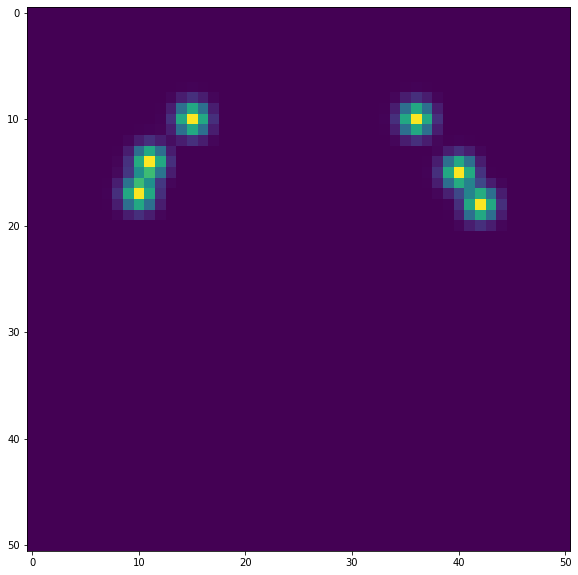

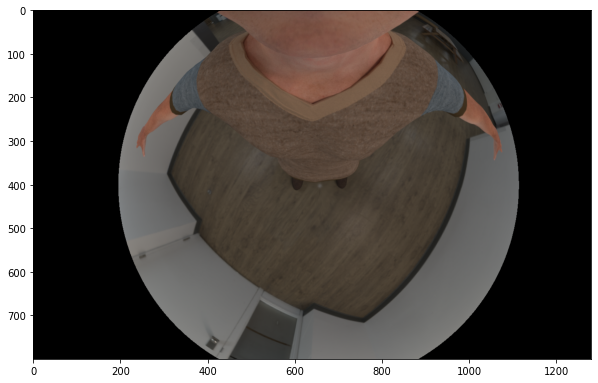

torch.Size([1, 3, 800, 1280])


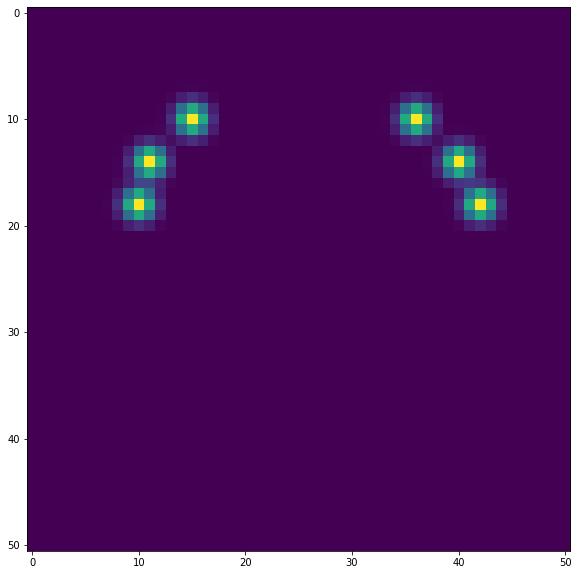

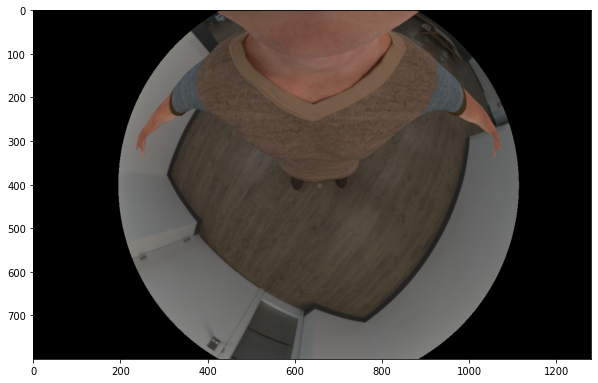

torch.Size([1, 3, 800, 1280])


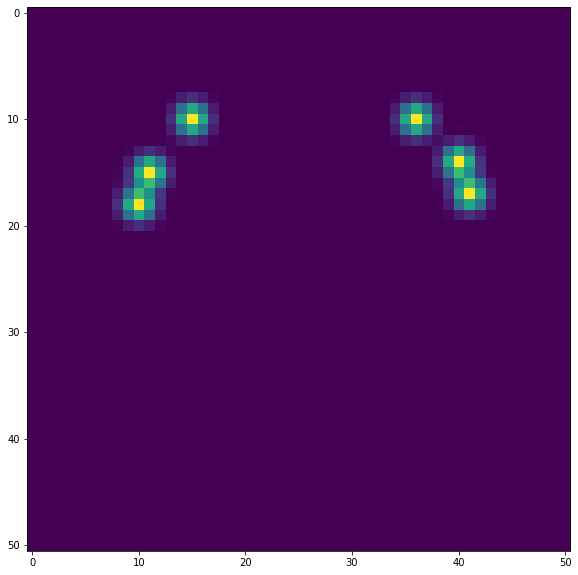

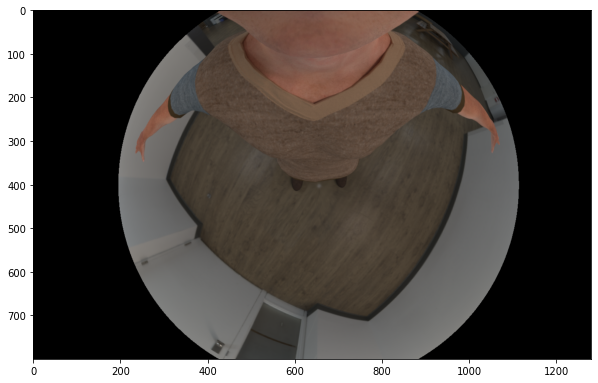

torch.Size([1, 3, 800, 1280])


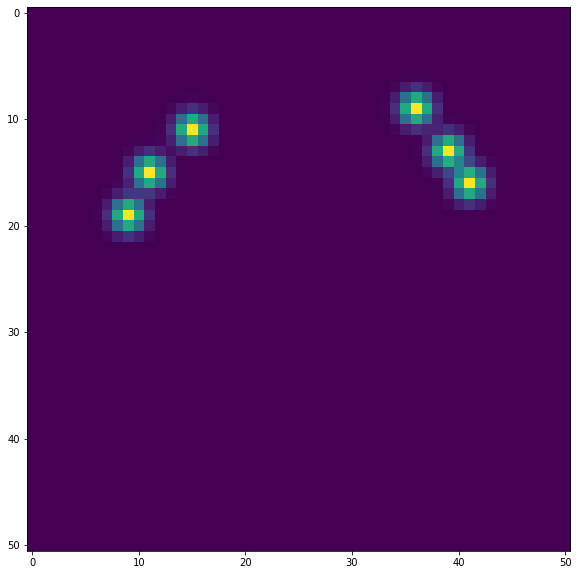

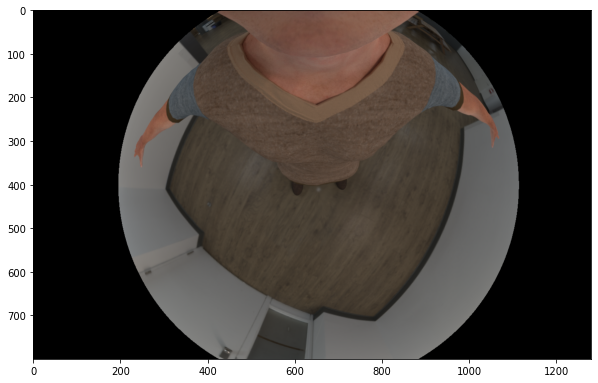

torch.Size([1, 3, 800, 1280])


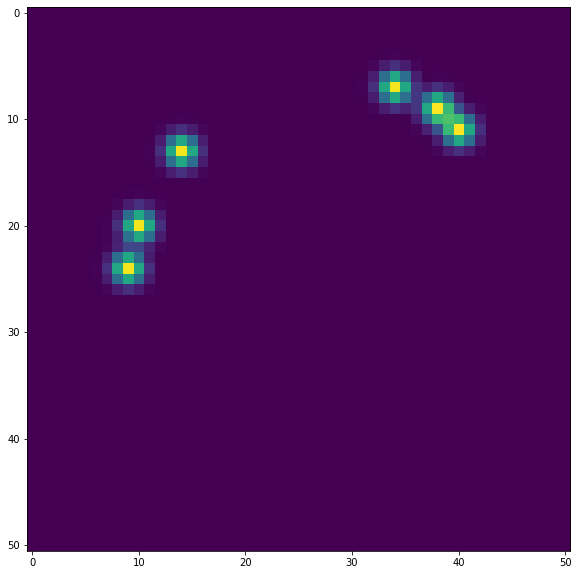

KeyboardInterrupt: 

In [45]:
i = 0
for sample in train_loader:
    img = sample[0]
    
    if i % 10 != 0:
        i+=1
        continue
    print(img.shape)
    plt.figure(figsize=(10,10))
    heatmap = sample[2][0]
    heatmap = np.sum(heatmap.numpy(), 0)
    plt.imshow(heatmap)
    plt.show()
    
    plt.figure(figsize=(10,10))
    img = np.transpose(img.numpy()[0], (1,2,0))
    plt.imshow(img)
    plt.show()
#     break
    if i >1000:
        break
    i+=1

In [ ]:

def train_model(model, pose_loss, heatmap_loss, heatmap_loss2, l1_loss, cos_loss, optimizer, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = float('inf')

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
#             running_̉corrects = 0

            # Iterate over data.
            sizes = {"train":0, "val":0}
            i = 0
            for image, gt_pose, gt_hm, gt_rot in dataloaders[phase]:
            
                image = image.to(device).float()
                gt_pose = gt_pose.to(device).float()
                gt_hm = gt_hm.to(device).float()
                gt_rot = gt_rot.to(device).float()

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    pred_pose, hm, pred_hm, pred_rot = model(image)
                    pred_pose = pred_pose.view(-1,6,3)
                    gt_pose = gt_pose.view(-1,6,3)
                    pred_rot = pred_rot.view(-1,6,3)
                    p_loss = pose_loss(pred_pose, gt_pose)
                    rot_loss = pose_loss(pred_rot, gt_rot)
                    cosine_loss = torch.mean(1 - cos_loss(pred_pose, gt_pose))
                    l1_loss_pose = l1_loss(pred_pose, gt_pose)
                    hmp_loss = heatmap_loss(hm, gt_hm)
                    hmp_emb_loss = heatmap_loss2(pred_hm, hm)

                    loss = p_loss + (hmp_loss/50) + (hmp_emb_loss/50) + (rot_loss/5000) #+ (l1_loss_pose) + (0.1*cosine_loss)
                    # backward + optimize only if in training phase
                    if phase == 'train':
            
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * image.size(0)
                sizes[phase] += image.size(0)
                if i % 10 == 0:
                    print(f"Phase {phase}: loss = {loss.item()} Step = {i}")
                    print("l2 pose",p_loss.item(), "hmp loss",hmp_loss.item(), "hmp2",hmp_emb_loss.item(), "rot_loss: ",rot_loss.item())# "l1 loss",l1_loss_pose.item(), "cos loss",cosine_loss.item())
                i += 1
                if i == 100  or i == 15000:
                    torch.save(model.state_dict(), f"./{i}th iteration.pth")
#                 running_corrects += torch.sum(preds == labels.data)
#             if phase == 'train':
#                 scheduler.step()

            epoch_loss = running_loss / sizes[phase]
#             epoch_acc = running_corrects.double() / dataset_sizes[phase]
            
            print('{} Loss: {:.4f}'.format(
                phase, epoch_loss))
       
            # deep copy the model
#             if epoch_loss < best_loss:
#                 best_loss = epoch_loss
#                 best_model_wts = copy.deepcopy(model.state_dict())

        print()
        torch.save(model.state_dict(), f"./{epoch}_epoch.pth")

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_loss))

    # load best model weights
    
#     model.load_state_dict(best_model_wts)
    return model

In [ ]:
# best = train_model(model, pose_criterion, hmp_loss, hmp_loss2, l1_loss, cos_sim, optimizer_ft, 1)

In [ ]:
model.load_state_dict(torch.load("./ckpts/57mm.pth" ),strict=False)

In [ ]:
def calculate_error(pred, gt):
#     error = np.sqrt(np.sum((pred - gt)**2, axis=2))
    return torch.mean(torch.sqrt(torch.sum((pred - gt)**2, axis=2))).cpu().item()

In [ ]:
def inference(model):
    results = []
    model.eval()   # Set model to evaluate mode
    phase="val"
    errors = []
    i=0
    print("infer")
    for image, gt_pose, hmp, _ in dataloaders["val"]: 
        image = image.to(device).float()
        gt_pose =  gt_pose.to(device).float()
        hmp =  hmp.to(device).float()
        with torch.set_grad_enabled(phase == 'train'):

            pose, hmp, hmp_pred,_ = model(image)
#             outputs = outputs.view(6,3).cpu().numpy()
#             inputs = inputs.cpu().numpy()[0]
#             inputs = np.transpose(inputs, (1,2,0))
#             labels = labels.reshape(17,3).cpu().numpy()
#             print(outputs)
#             labels1 = labels.copy()
#             labels1[4:10] = outputs* 300
#             plot((labels, labels1), inputs)

#             plot(labels, inputs)
            pose = pose.reshape(-1,6,3)
            gt_pose = gt_pose.reshape(-1,6,3)
            err = calculate_error(pose*300, gt_pose*300)
            errors.append(err)
#             print(errors)
            if i % 10 == 0:
                print(i, err, np.mean(errors))
            i+=1

#             0/0
#             inputs = np.transpose(inputs.detach().cpu().numpy(), (0,2,3,1))
#             outputs = (outputs * 224).reshape(-1, 6,2)
#             for im, joints in zip(inputs, outputs):
#                 plt.figure(figsize=(10,10))
#                 im = (im * 255)
#                 im[im > 255] = 255
#                 im[im < 0] = 0
#                 im = im.astype("uint8")
#                 im = np.ascontiguousarray(im, dtype=np.uint8)

#                 print(im.shape, np.min(im))
#                 for joint in joints:  
#                     joint = joint.detach().cpu().numpy()
#                     cv2.circle(im, (int(joint[0]), int(joint[1])), radius=5, color=(255, 255, 0), thickness=-1)
#                 plt.imshow(im)
#                 plt.show()

    return errors
errors = inference(model)
    

In [ ]:
np.mean(errors)

## 